In [1]:
from assignment_rise.utils.nerd_handler import NERDData
from assignment_rise.utils.labels import SYSTEM_B_LABELS_ID

data = NERDData('en', target_labels_id=SYSTEM_B_LABELS_ID)
tokenized_data = data.tokenize_and_align()

/archive/projects/a.ihsan/assignment-rise/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/archive/projects/a.ihsan/assignment-rise/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Resolving data files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 102675.74it/s]


In [2]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from peft import PeftConfig, PeftModel, get_peft_model

lora_adapter_chkpt = '../lora_system_B/'
lora_config = PeftConfig.from_pretrained(lora_adapter_chkpt)

model = AutoModelForTokenClassification.from_pretrained(
    lora_config.base_model_name_or_path,
    device_map='auto', 
    num_labels=len(data.target_id_labels),
    id2label=data.target_id_labels,
    label2id=data.target_labels_id
)
tokenizer = AutoTokenizer.from_pretrained(lora_config.base_model_name_or_path, add_prefix_space=True)
lora_model = PeftModel.from_pretrained(model, lora_adapter_chkpt)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from torch.nn.functional import cross_entropy
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

def forward_pass_with_label(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    with torch.no_grad():
        output = lora_model.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).numpy()
    loss = cross_entropy(output.logits.view(-1, len(data.target_id_labels)), 
                        labels.view(-1), reduction='none')
    loss = loss.view(len(input_ids), -1).numpy()
    return {'loss':loss, 'predicted_label':predicted_label}

test_data_analyze=tokenized_data['test'].map(forward_pass_with_label, batched=True, batch_size=32)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32908/32908 [01:27<00:00, 374.41 examples/s]


In [4]:
df = test_data_analyze.to_pandas()

data.target_id_labels[-100] = 'IGN'
df['input_tokens'] = df['input_ids'].apply(
    lambda x:tokenizer.convert_ids_to_tokens(x))

df['predicted_label'] = df['predicted_label'].apply(
    lambda x: [data.target_id_labels[i] for i in x])

df['labels'] = df['labels'].apply(
    lambda x: [data.target_id_labels[i] for i in x])

df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)

df['predicted_label']=df.apply(
    lambda x:x['predicted_label'][:len(x['input_ids'])], axis=1)

df.sample(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
28435,"[0, 832, 11204, 2156, 2094, 6945, 2552, 219, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, B-PER, I-PER, IGN, IGN, O, O, O...","[0.0, 2.503392e-06, 4.5299425e-06, 1.5497195e-...","[O, O, O, O, B-PER, I-PER, I-PER, I-PER, O, O,...","[<s>, ĠHis, Ġcousin, Ġ,, ĠLee, ĠFe, ene, y, Ġ,..."


In [5]:
import pandas as pd
df_tokens = df.apply(pd.Series.explode)

In [6]:
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,832,1,O,0.0,O,ĠHis
0,1150,1,O,0.0,O,Ġfather
0,21,1,O,0.0,O,Ġwas
0,10,1,O,0.0,O,Ġa
0,2658,1,O,0.0,O,Ġsurvey
0,8,1,O,0.0,O,Ġand
0,40128,1,O,0.0,O,Ġtavern


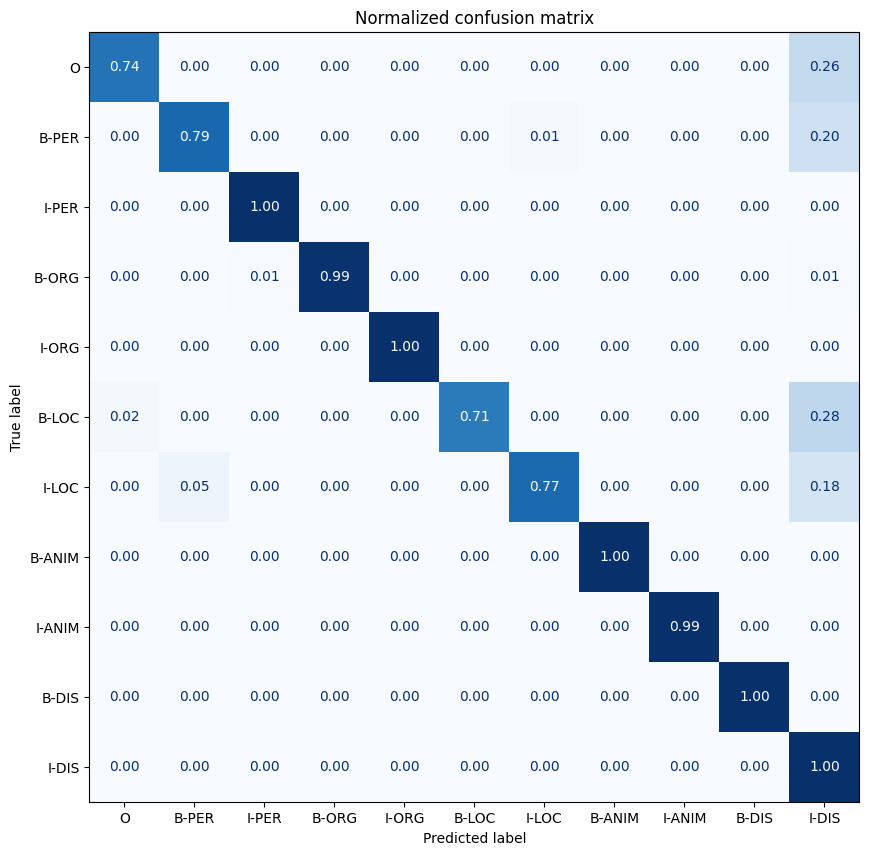

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], data.target_labels_list)

The confusion matrix shows that the model confuses the I-DIS, B-PER, B-LOC and I-LOC entities.

In [10]:
(df_tokens.groupby('labels')[['loss']].agg(['count', 'mean', 'sum']).droplevel(level=0, axis=1).sort_values(by='mean', ascending=False).reset_index().round(2).T)

,0,1,2,3,4,5,6,7,8,9,10
labels,I-DIS,B-DIS,I-ANIM,B-ANIM,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,O,I-PER
count,1004,1518,1852,3208,6618,11926,9162,24048,10530,612724,11460
mean,1.07,0.68,0.62,0.62,0.05,0.03,0.02,0.02,0.02,0.01,0.0
sum,1070.26,1030.38,1149.68,1983.0,326.78,314.38,211.54,531.74,191.44,4621.14,46.16


Given the table above, the model finds it challenging to predict the inside of the disease entity (I-DIS)